<a href="https://colab.research.google.com/github/PaiHwai22/LoanDefaultPrediction/blob/main/LDP_HistGradBoost_85%25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importing Libraries**

In [ ]:
# libraries
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt  # plotting simple plots
import numpy as np  # linear algebra
import os  # access directory structure
import pandas as pd  # data processing
import seaborn as sns  # plotting visual plots
from sklearn.model_selection import train_test_split # data splits
from sklearn.preprocessing import MinMaxScaler # for normalizing data

import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression # model import (logistic regression)

In [ ]:
# Logistic Regression
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score, roc_curve, auc

**data preprocessing and feature engineering techniques**


---
* create new binary features
* string to float conversions
* one-hot-encode for object dtype
* feature scaling
* engineer new features
* drop unnecessary columns

**Data Pre-Processing**

In [ ]:
# Read csv files into df
UserInfo = pd.read_csv('/content/user_info.csv', index_col = 0)
NextMonths = pd.read_csv('/content/next_months.csv', index_col = 0)
PastMonths = pd.read_csv('/content/past_months.csv', index_col = 0)

In [ ]:
# Merge dataframes
merged_data = pd.merge(NextMonths, PastMonths, how='outer')
merged_data = pd.merge(merged_data, UserInfo, on='user_id', how='inner')

In [ ]:
merged_data.head()

,month,default_value,user_id,registration_date,years_of_study,family_size,loan_amount,total_career_years,birth_date,contract_type,is_male,province,zip_code,age,group,history_type,monthly_expense
0,2013-11-01,0,821302,2012-01-21,1.0,0.0,187956,3.0,1987-10-15,A,0.0,A,300057.0,24.0,A,A,14500.0
1,2013-10-01,0,821302,2012-01-21,1.0,0.0,187956,3.0,1987-10-15,A,0.0,A,300057.0,24.0,A,A,14500.0
2,2013-09-01,0,821302,2012-01-21,1.0,0.0,187956,3.0,1987-10-15,A,0.0,A,300057.0,24.0,A,A,14500.0
3,2013-08-01,0,821302,2012-01-21,1.0,0.0,187956,3.0,1987-10-15,A,0.0,A,300057.0,24.0,A,A,14500.0
4,2013-07-01,0,821302,2012-01-21,1.0,0.0,187956,3.0,1987-10-15,A,0.0,A,300057.0,24.0,A,A,14500.0


In [ ]:
# the current default_value column is listed as 0 and none 0. We want to change this to 0, 1 values to help in categorization.
merged_data['default_value'] = merged_data['default_value'].where(merged_data['default_value'] == 0, 1)

**Train Test Split**

In [ ]:
# setting seed to generate new numbers on each run
seed = 11

In [ ]:
# Split the merged data into training and testing sets
X = merged_data.loc[:, merged_data.columns != 'default_value']
y = merged_data.loc[:,merged_data.columns == 'default_value']

# split train test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

In [ ]:
# inspecting our target feature
y_train.head()

,default_value
143119,0
116167,1
70825,0
96206,0
151435,1


Text(0.5, 1.0, 'Bar Plot of default_value')

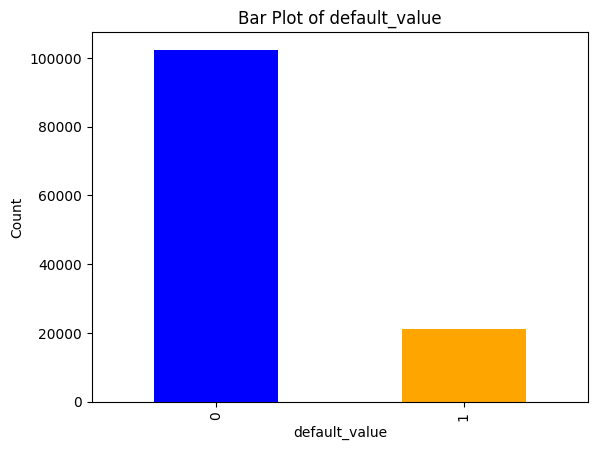

In [ ]:
# Create a bar plot
y_train['default_value'].value_counts().plot(kind='bar', color=['blue', 'orange'])

# Set plot labels and title
plt.xlabel('default_value')
plt.ylabel('Count')
plt.title('Bar Plot of default_value')

In [ ]:
y_train['default_value'].value_counts()

0    102371
1     21281
Name: default_value, dtype: int64



---

*`We make a note to resample our target feature to balance the weights. `*

---



In [ ]:
X_train.head()

,month,user_id,registration_date,years_of_study,family_size,loan_amount,total_career_years,birth_date,contract_type,is_male,province,zip_code,age,group,history_type,monthly_expense
143119,2012-12-01,944594,2012-04-19,NaN,0.0,130890,NaN,1985-07-08,C,0.0,I,125204.0,27.0,B,B,1000.0
116167,2013-05-01,923386,2012-03-31,NaN,0.0,118374,NaN,2064-01-01,E,1.0,I,124122.0,48.0,B,A,16000.0
70825,2013-08-01,1053131,2012-06-24,NaN,2.0,134934,NaN,2063-09-01,E,1.0,K,282480.0,49.0,B,C,25000.0
96206,2013-08-01,901933,2012-03-18,5.0,0.0,184587,5.0,2049-12-10,E,1.0,L,583101.0,62.0,B,A,20000.0
151435,2012-12-01,1003497,2012-05-24,30.0,3.0,165399,30.0,2063-07-18,A,1.0,O,490014.0,49.0,B,A,16000.0


In [ ]:
# Inspect Null Values in Train
nRow, nCol = X_train.shape
print(f" Train features has {nRow} rows and {nCol} columns. \n")
null_columns = X_train.isnull().sum().sort_values(ascending=False)
print(f"Columns with null values: \n{null_columns[null_columns > 0]}")

 Train features has 123652 rows and 16 columns. 

Columns with null values: 
years_of_study        86932
total_career_years    86932
history_type            219
dtype: int64


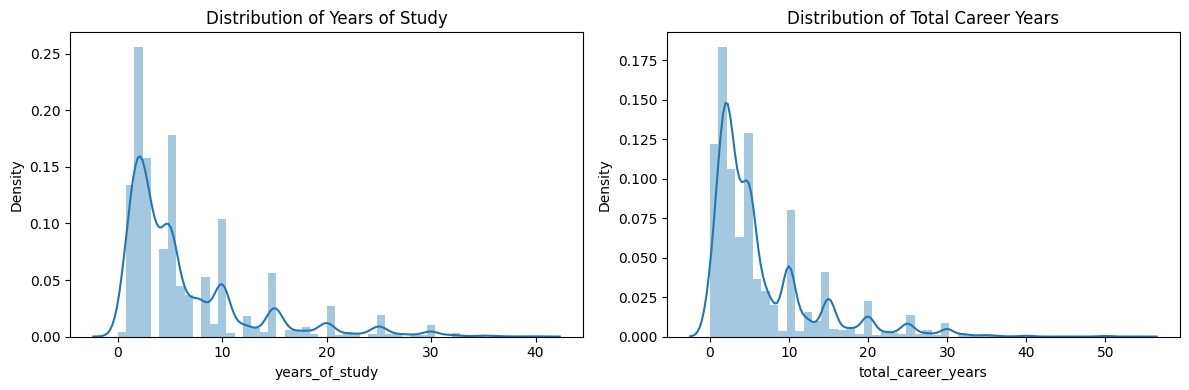

In [ ]:
# Visualize Null Features in Train Data
# Create a figure with two subplots
plt.figure(figsize=(12, 4))

# Plot the distribution of 'years_of_study' on the left
plt.subplot(121)
sns.distplot(X_train['years_of_study'])
plt.title('Distribution of Years of Study')

# Plot the distribution of 'total_career_years' on the right
plt.subplot(122)
sns.distplot(X_train['total_career_years'])
plt.title('Distribution of Total Career Years')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

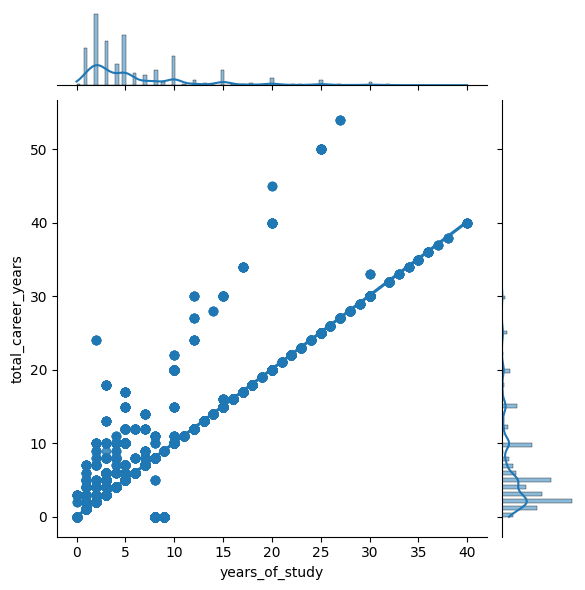

In [ ]:
# Create a joint distribution plot to visualize the distribution and relationship
sns.jointplot(x='years_of_study', y='total_career_years', data=X_train, kind='reg')

plt.show()

In [ ]:
# Calculate the correlation coefficient (Pearson's)
correlation_coefficient = X_train['years_of_study'].corr(X_train['total_career_years'])
print(f'Correlation coefficient: {correlation_coefficient}')

Correlation coefficient: 0.9450736715254011


**`Feature Engineering`**

In [ ]:
## copy train to df for testing
df = X_train.copy()

In [ ]:
# combine correlated variables and drop columns to reduce multicolinearity
df['edu_career_years'] = df.apply(lambda x: x['total_career_years'] + x['years_of_study'],axis=1)
df = df.drop(['total_career_years','years_of_study'],axis=1)
df.head()

,month,user_id,registration_date,family_size,loan_amount,birth_date,contract_type,is_male,province,zip_code,age,group,history_type,monthly_expense,edu_career_years
143119,2012-12-01,944594,2012-04-19,0.0,130890,1985-07-08,C,0.0,I,125204.0,27.0,B,B,1000.0,NaN
116167,2013-05-01,923386,2012-03-31,0.0,118374,2064-01-01,E,1.0,I,124122.0,48.0,B,A,16000.0,NaN
70825,2013-08-01,1053131,2012-06-24,2.0,134934,2063-09-01,E,1.0,K,282480.0,49.0,B,C,25000.0,NaN
96206,2013-08-01,901933,2012-03-18,0.0,184587,2049-12-10,E,1.0,L,583101.0,62.0,B,A,20000.0,10.0
151435,2012-12-01,1003497,2012-05-24,3.0,165399,2063-07-18,A,1.0,O,490014.0,49.0,B,A,16000.0,60.0


In [ ]:
## apply this new feature to test set as well
X_test['edu_career_years'] = X_test.apply(lambda x: x['total_career_years'] + x['years_of_study'],axis=1)
X_test = X_test.drop(['total_career_years','years_of_study'],axis=1)
X_test.head()

,month,user_id,registration_date,family_size,loan_amount,birth_date,contract_type,is_male,province,zip_code,age,group,history_type,monthly_expense,edu_career_years
114665,2013-11-01,1002476,2012-05-24,0.0,135300,1991-04-01,D,1.0,M,34003.0,21.0,A,C,12500.0,8.0
54227,2012-09-01,840322,2012-01-30,0.0,165399,2061-01-01,E,1.0,K,280001.0,51.0,B,B,20000.0,NaN
135991,2012-12-01,798030,2012-05-01,3.0,141888,1991-01-01,E,1.0,I,143303.0,21.0,B,C,14600.0,NaN
126338,2012-11-01,949246,2012-04-21,0.0,165399,1966-06-01,E,1.0,K,265601.0,46.0,B,B,14000.0,NaN
57110,2013-04-01,873294,2012-02-27,0.0,149796,1988-07-15,B,1.0,K,282210.0,24.0,B,C,10000.0,8.0


# New Section

In [ ]:
# check new feature column
df['edu_career_years'].describe()

count    36720.000000
mean        12.966449
std         12.899715
min          0.000000
25%          4.000000
50%          8.000000
75%         16.000000
max         81.000000
Name: edu_career_years, dtype: float64

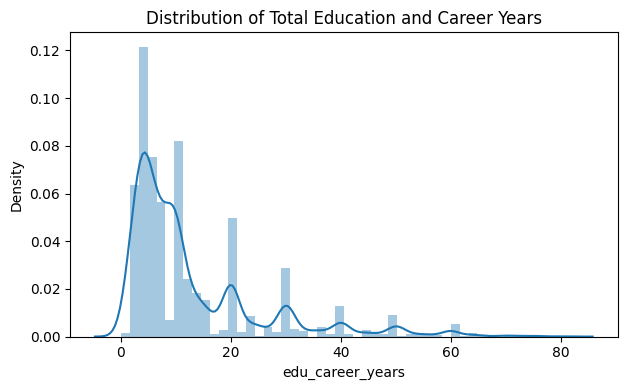

In [ ]:
# set layout
plt.figure(figsize=(12, 4))

# Plot the distribution of 'edu_career_years'
plt.subplot(122)
sns.distplot(df['edu_career_years'])
plt.title('Distribution of Total Education and Career Years')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

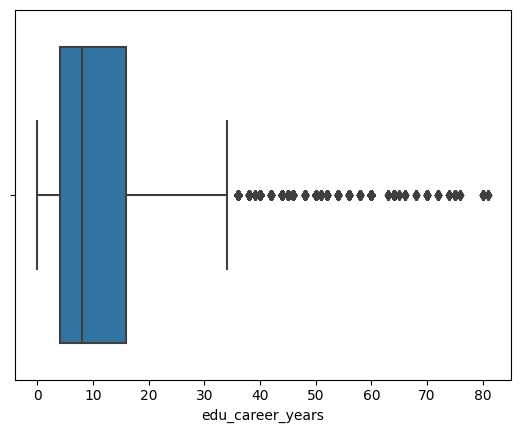

In [ ]:
# boxplot of skewed features
sns.boxplot(x = df['edu_career_years'])
plt.show()

In [ ]:
#create a function to find outliers using IQR
def find_outliers_IQR(df):
   q1=df.quantile(0.25)
   q3=df.quantile(0.75)
   IQR=q3-q1
   outliers = df[((df<(q1-1.5*IQR)) | (df>(q3+1.5*IQR)))]
   return outliers

In [ ]:
# find outliers
outliers = find_outliers_IQR(df['edu_career_years'])
outliers

151435    60.0
115467    60.0
72058     36.0
24157     40.0
151024    38.0
          ... 
1089      40.0
78203     46.0
1427      40.0
22776     36.0
79093     50.0
Name: edu_career_years, Length: 2814, dtype: float64

In [ ]:
# drop outliers
df['edu_career_years'] = (df['edu_career_years']).drop(outliers.index)

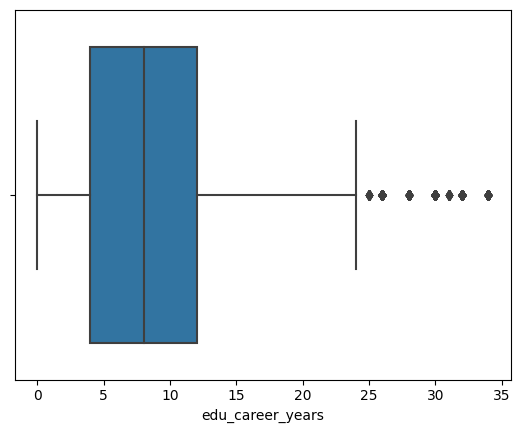

In [ ]:
# check column after dropping outliers
sns.boxplot(x = df['edu_career_years'])
plt.show()

In [ ]:
# check missing values
df['edu_career_years'].isnull().sum()

89746

In [ ]:
# count non missing values
df['edu_career_years'].count()

33906

**Impute Missing Values with MICE**

In [ ]:
# import and enable MICE
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [ ]:
# Define imputer
imputer = IterativeImputer(random_state=100, max_iter=100)

In [ ]:
df.head()

,month,user_id,registration_date,family_size,loan_amount,birth_date,contract_type,is_male,province,zip_code,age,group,history_type,monthly_expense,edu_career_years
143119,2012-12-01,944594,2012-04-19,0.0,130890,1985-07-08,C,0.0,I,125204.0,27.0,B,B,1000.0,NaN
116167,2013-05-01,923386,2012-03-31,0.0,118374,2064-01-01,E,1.0,I,124122.0,48.0,B,A,16000.0,NaN
70825,2013-08-01,1053131,2012-06-24,2.0,134934,2063-09-01,E,1.0,K,282480.0,49.0,B,C,25000.0,NaN
96206,2013-08-01,901933,2012-03-18,0.0,184587,2049-12-10,E,1.0,L,583101.0,62.0,B,A,20000.0,10.0
151435,2012-12-01,1003497,2012-05-24,3.0,165399,2063-07-18,A,1.0,O,490014.0,49.0,B,A,16000.0,NaN


In [ ]:
# concat target feature to df
df = pd.concat([df, y_train.copy()], axis=1)

In [ ]:
df.head()

,month,user_id,registration_date,family_size,loan_amount,birth_date,contract_type,is_male,province,zip_code,age,group,history_type,monthly_expense,edu_career_years,default_value
143119,2012-12-01,944594,2012-04-19,0.0,130890,1985-07-08,C,0.0,I,125204.0,27.0,B,B,1000.0,NaN,0
116167,2013-05-01,923386,2012-03-31,0.0,118374,2064-01-01,E,1.0,I,124122.0,48.0,B,A,16000.0,NaN,1
70825,2013-08-01,1053131,2012-06-24,2.0,134934,2063-09-01,E,1.0,K,282480.0,49.0,B,C,25000.0,NaN,0
96206,2013-08-01,901933,2012-03-18,0.0,184587,2049-12-10,E,1.0,L,583101.0,62.0,B,A,20000.0,10.0,0
151435,2012-12-01,1003497,2012-05-24,3.0,165399,2063-07-18,A,1.0,O,490014.0,49.0,B,A,16000.0,NaN,1


In [ ]:
# Use numerical features
imp_train = df.loc[:, ['user_id', 'family_size', 'loan_amount','is_male', 'zip_code', 'age', 'monthly_expense', 'edu_career_years', 'default_value']]
imp_train.head()

,user_id,family_size,loan_amount,is_male,zip_code,age,monthly_expense,edu_career_years,default_value
143119,944594,0.0,130890,0.0,125204.0,27.0,1000.0,NaN,0
116167,923386,0.0,118374,1.0,124122.0,48.0,16000.0,NaN,1
70825,1053131,2.0,134934,1.0,282480.0,49.0,25000.0,NaN,0
96206,901933,0.0,184587,1.0,583101.0,62.0,20000.0,10.0,0
151435,1003497,3.0,165399,1.0,490014.0,49.0,16000.0,NaN,1


In [ ]:
# fit on the dataset
imputer.fit(imp_train)

IterativeImputer(max_iter=100, random_state=100)

In [ ]:
# predict missing values
df_imputed = imputer.transform(imp_train)

In [ ]:
df_imputed[:10]

array([[9.44594000e+05, 0.00000000e+00, 1.30890000e+05, 0.00000000e+00,
        1.25204000e+05, 2.70000000e+01, 1.00000000e+03, 7.26827052e+00,
        0.00000000e+00],
       [9.23386000e+05, 0.00000000e+00, 1.18374000e+05, 1.00000000e+00,
        1.24122000e+05, 4.80000000e+01, 1.60000000e+04, 1.52010320e+01,
        1.00000000e+00],
       [1.05313100e+06, 2.00000000e+00, 1.34934000e+05, 1.00000000e+00,
        2.82480000e+05, 4.90000000e+01, 2.50000000e+04, 1.65899705e+01,
        0.00000000e+00],
       [9.01933000e+05, 0.00000000e+00, 1.84587000e+05, 1.00000000e+00,
        5.83101000e+05, 6.20000000e+01, 2.00000000e+04, 1.00000000e+01,
        0.00000000e+00],
       [1.00349700e+06, 3.00000000e+00, 1.65399000e+05, 1.00000000e+00,
        4.90014000e+05, 4.90000000e+01, 1.60000000e+04, 1.56459044e+01,
        1.00000000e+00],
       [8.42065000e+05, 0.00000000e+00, 1.18374000e+05, 1.00000000e+00,
        6.11303000e+05, 2.10000000e+01, 1.20000000e+04, 4.95840564e+00,
        0.0

In [ ]:
# Replace with imputed values
df.loc[:, ['user_id', 'family_size', 'loan_amount','is_male', 'zip_code', 'age', 'monthly_expense', 'edu_career_years', 'default_value']] = df_imputed
df.head(10)

,month,user_id,registration_date,family_size,loan_amount,birth_date,contract_type,is_male,province,zip_code,age,group,history_type,monthly_expense,edu_career_years,default_value
143119,2012-12-01,944594.0,2012-04-19,0.0,130890.0,1985-07-08,C,0.0,I,125204.0,27.0,B,B,1000.0,7.268271,0.0
116167,2013-05-01,923386.0,2012-03-31,0.0,118374.0,2064-01-01,E,1.0,I,124122.0,48.0,B,A,16000.0,15.201032,1.0
70825,2013-08-01,1053131.0,2012-06-24,2.0,134934.0,2063-09-01,E,1.0,K,282480.0,49.0,B,C,25000.0,16.589971,0.0
96206,2013-08-01,901933.0,2012-03-18,0.0,184587.0,2049-12-10,E,1.0,L,583101.0,62.0,B,A,20000.0,10.000000,0.0
151435,2012-12-01,1003497.0,2012-05-24,3.0,165399.0,2063-07-18,A,1.0,O,490014.0,49.0,B,A,16000.0,15.645904,1.0
9597,2013-02-01,842065.0,2012-03-02,0.0,118374.0,1990-10-22,E,1.0,G,611303.0,21.0,A,C,12000.0,4.958406,0.0
43946,2013-10-01,1048123.0,2012-06-23,2.0,147615.0,1992-01-01,B,1.0,I,183126.0,20.0,B,C,8000.0,6.000000,0.0
25446,2012-09-01,797732.0,2012-04-01,0.0,155244.0,1987-01-01,E,1.0,I,182009.0,25.0,A,B,12000.0,8.085221,0.0
9811,2013-09-01,849325.0,2012-09-02,3.0,142734.0,1979-01-01,E,1.0,G,611302.0,33.0,B,B,15000.0,10.476994,0.0
109235,2013-01-01,1033484.0,2012-06-14,4.0,136059.0,1978-01-01,C,1.0,J,201707.0,34.0,B,B,15000.0,12.461060,1.0


In [ ]:
df.isnull().sum()

month                  0
user_id                0
registration_date      0
family_size            0
loan_amount            0
birth_date             0
contract_type          0
is_male                0
province               0
zip_code               0
age                    0
group                  0
history_type         219
monthly_expense        0
edu_career_years       0
default_value          0
dtype: int64

In [ ]:
# drop rows with missing values
df = df.dropna()
df.isnull().sum()

month                0
user_id              0
registration_date    0
family_size          0
loan_amount          0
birth_date           0
contract_type        0
is_male              0
province             0
zip_code             0
age                  0
group                0
history_type         0
monthly_expense      0
edu_career_years     0
default_value        0
dtype: int64

In [ ]:
# check y_train shape
y_train.shape

(123652, 1)

In [ ]:
# replace y_train with df target feature column where missing value rows are dropped
y_train = df['default_value']

In [ ]:
y_train.shape

(123433,)

In [ ]:
# drop target feature column
df = df.drop('default_value', axis=1)

In [ ]:
df.head()

,month,user_id,registration_date,family_size,loan_amount,birth_date,contract_type,is_male,province,zip_code,age,group,history_type,monthly_expense,edu_career_years
143119,2012-12-01,944594.0,2012-04-19,0.0,130890.0,1985-07-08,C,0.0,I,125204.0,27.0,B,B,1000.0,7.268271
116167,2013-05-01,923386.0,2012-03-31,0.0,118374.0,2064-01-01,E,1.0,I,124122.0,48.0,B,A,16000.0,15.201032
70825,2013-08-01,1053131.0,2012-06-24,2.0,134934.0,2063-09-01,E,1.0,K,282480.0,49.0,B,C,25000.0,16.589971
96206,2013-08-01,901933.0,2012-03-18,0.0,184587.0,2049-12-10,E,1.0,L,583101.0,62.0,B,A,20000.0,10.000000
151435,2012-12-01,1003497.0,2012-05-24,3.0,165399.0,2063-07-18,A,1.0,O,490014.0,49.0,B,A,16000.0,15.645904


In [ ]:
df.shape

(123433, 15)

In [ ]:
# Apply the engineered features on Train
X_train = df.copy()

In [ ]:
# Pre processing function
def preprocess_dataframe(df):

    # Define the list of string columns to remove special characters and convert to float
    string_columns = ['registration_date', 'birth_date', 'month']

    # Remove special characters from string columns
    df[string_columns] = df[string_columns].replace(r'\W', '', regex=True)

    # Convert string columns to float
    df[string_columns] = df[string_columns].astype(float)

    # Create dummy variables for categorical columns
    df_dummies = pd.get_dummies(df[['contract_type', 'province', 'group', 'history_type']], drop_first=True)

    # Concatenate the dummy variables with the original DataFrame
    df = pd.concat([df, df_dummies], axis=1)

    # Drop the original categorical columns
    df = df.drop(['contract_type', 'province', 'group', 'history_type'], axis=1)

    return df

In [ ]:
X_train = preprocess_dataframe(X_train)

In [ ]:
X_train.head()

,month,user_id,registration_date,family_size,loan_amount,birth_date,is_male,zip_code,age,monthly_expense,...,province_L,province_M,province_N,province_O,group_B,group_C,group_D,history_type_B,history_type_C,history_type_D
143119,20121201.0,944594.0,20120419.0,0.0,130890.0,19850708.0,0.0,125204.0,27.0,1000.0,...,0,0,0,0,1,0,0,1,0,0
116167,20130501.0,923386.0,20120331.0,0.0,118374.0,20640101.0,1.0,124122.0,48.0,16000.0,...,0,0,0,0,1,0,0,0,0,0
70825,20130801.0,1053131.0,20120624.0,2.0,134934.0,20630901.0,1.0,282480.0,49.0,25000.0,...,0,0,0,0,1,0,0,0,1,0
96206,20130801.0,901933.0,20120318.0,0.0,184587.0,20491210.0,1.0,583101.0,62.0,20000.0,...,1,0,0,0,1,0,0,0,0,0
151435,20121201.0,1003497.0,20120524.0,3.0,165399.0,20630718.0,1.0,490014.0,49.0,16000.0,...,0,0,0,1,1,0,0,0,0,0


In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 123433 entries, 143119 to 141209
Data columns (total 35 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   month              123433 non-null  float64
 1   user_id            123433 non-null  float64
 2   registration_date  123433 non-null  float64
 3   family_size        123433 non-null  float64
 4   loan_amount        123433 non-null  float64
 5   birth_date         123433 non-null  float64
 6   is_male            123433 non-null  float64
 7   zip_code           123433 non-null  float64
 8   age                123433 non-null  float64
 9   monthly_expense    123433 non-null  float64
 10  edu_career_years   123433 non-null  float64
 11  contract_type_B    123433 non-null  uint8  
 12  contract_type_C    123433 non-null  uint8  
 13  contract_type_D    123433 non-null  uint8  
 14  contract_type_E    123433 non-null  uint8  
 15  province_B         123433 non-null  uint8  
 1

In [ ]:
X_test = preprocess_dataframe(X_test)

In [ ]:
X_test.head()

,month,user_id,registration_date,family_size,loan_amount,birth_date,is_male,zip_code,age,monthly_expense,...,province_L,province_M,province_N,province_O,group_B,group_C,group_D,history_type_B,history_type_C,history_type_D
114665,20131101.0,1002476,20120524.0,0.0,135300,19910401.0,1.0,34003.0,21.0,12500.0,...,0,1,0,0,0,0,0,0,1,0
54227,20120901.0,840322,20120130.0,0.0,165399,20610101.0,1.0,280001.0,51.0,20000.0,...,0,0,0,0,1,0,0,1,0,0
135991,20121201.0,798030,20120501.0,3.0,141888,19910101.0,1.0,143303.0,21.0,14600.0,...,0,0,0,0,1,0,0,0,1,0
126338,20121101.0,949246,20120421.0,0.0,165399,19660601.0,1.0,265601.0,46.0,14000.0,...,0,0,0,0,1,0,0,1,0,0
57110,20130401.0,873294,20120227.0,0.0,149796,19880715.0,1.0,282210.0,24.0,10000.0,...,0,0,0,0,1,0,0,0,1,0


In [ ]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30913 entries, 114665 to 145015
Data columns (total 35 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   month              30913 non-null  float64
 1   user_id            30913 non-null  int64  
 2   registration_date  30913 non-null  float64
 3   family_size        30913 non-null  float64
 4   loan_amount        30913 non-null  int64  
 5   birth_date         30913 non-null  float64
 6   is_male            30913 non-null  float64
 7   zip_code           30913 non-null  float64
 8   age                30913 non-null  float64
 9   monthly_expense    30913 non-null  float64
 10  edu_career_years   8977 non-null   float64
 11  contract_type_B    30913 non-null  uint8  
 12  contract_type_C    30913 non-null  uint8  
 13  contract_type_D    30913 non-null  uint8  
 14  contract_type_E    30913 non-null  uint8  
 15  province_B         30913 non-null  uint8  
 16  province_C      

**Normalizing with MinMaxScaler**

In [ ]:
# Initialize the MinMaxScaler
scaler = MinMaxScaler(feature_range = (0,1))
scaler.fit(X_train)
X_train = scaler.transform(X_train)

**Resampling Target Feature**

In [ ]:
# over sampling target feature
from imblearn.over_sampling import SMOTE

s = {0: 102220, 1: 102220}  # number of oversampling in class is greater than original number

# Fit and transform the training data (X_train, y_train) using SMOTE
X_train_resampled, y_train_resampled = SMOTE(sampling_strategy= s, random_state= seed).fit_resample(X_train, y_train)

In [ ]:
y_train_resampled.value_counts()

0.0    102220
1.0    102220
Name: default_value, dtype: int64

***inspecting our testing data***

In [ ]:
X_test.head()

,month,user_id,registration_date,family_size,loan_amount,birth_date,is_male,zip_code,age,monthly_expense,...,province_L,province_M,province_N,province_O,group_B,group_C,group_D,history_type_B,history_type_C,history_type_D
114665,20131101.0,1002476,20120524.0,0.0,135300,19910401.0,1.0,34003.0,21.0,12500.0,...,0,1,0,0,0,0,0,0,1,0
54227,20120901.0,840322,20120130.0,0.0,165399,20610101.0,1.0,280001.0,51.0,20000.0,...,0,0,0,0,1,0,0,1,0,0
135991,20121201.0,798030,20120501.0,3.0,141888,19910101.0,1.0,143303.0,21.0,14600.0,...,0,0,0,0,1,0,0,0,1,0
126338,20121101.0,949246,20120421.0,0.0,165399,19660601.0,1.0,265601.0,46.0,14000.0,...,0,0,0,0,1,0,0,1,0,0
57110,20130401.0,873294,20120227.0,0.0,149796,19880715.0,1.0,282210.0,24.0,10000.0,...,0,0,0,0,1,0,0,0,1,0


In [ ]:
y_test.head()

,default_value
114665,1
54227,0
135991,1
126338,0
57110,0


**Saving our split data on CSV**

In [ ]:
# our train data normalized (post smote) is in array type
np.savetxt('X_train_resampled.csv', X_train_resampled, delimiter=',')

In [ ]:
# our train target feature data is not normalized but post smote is in series type
df_ytrain = pd.DataFrame(y_train_resampled)

In [ ]:
df_ytrain.to_csv('y_train_resampled.csv', index=True)

In [ ]:
X_test.to_csv('X_test.csv', index=True)
y_test.to_csv('y_test.csv', index =True)

 **Pre Processing Report**
---


>


Our **Testing data** is untouched except for 2 aspects. applying the pre-processing function which encodes our features into numerical type. There are still null values.

Some models do not accept nulll value inputs. Logistic Regression for example, only allows non null numerical values.

We also dropped 2 feature columns and applied additional arithmetic to the testing data. This is okay to do because in production, the inputing data can also be altered the same way as it makes sense to do so.
>


Our **Training data** is preprocessed and transformed in the following ways.

For `*Data Engineering*`, multicolinearity is dealt with creating new features using additiion arithmetics. Addition is used because of the relational sematics of the 2 correlated features. We also remove outliers of highly correlated features using IQR math applications. It is visualized with box plots. This is important for null value imputation as we are using a regressor model and removing outliers reduce bias and variance. Since the outliers are few considering the size of the dataset, we can consider omitting them.

Due to high number of null values in the training data, it is imputed with the `MICE algorithm`. This is more accurate than using arithmetic imputation as it is a multivariate regressor. The imputed values are estimated by other numerical features.

The training data also uses `SMOTE` to balance the weight of our target feature. This is important as unbalanced training data will affect the model evalation. There may be more false positives and more false negatives due to the bias of unweighted target feature. We use oversampling method for the default counts.


## **Histogram Gradient Boosting Classifier Model Implementation**

In [ ]:
# clear the model state

In [ ]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.experimental import enable_hist_gradient_boosting

In [ ]:
hgb_clf = HistGradientBoostingClassifier()
hgb_clf.fit(X_train, y_train)
y_pred = hgb_clf.predict(X_test)

In [ ]:
from sklearn import metrics
print("Accuracy", metrics.accuracy_score(y_test, y_pred)*100)

Accuracy 65.38026073173098


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score

In [ ]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[17834  7756]
 [ 2946  2377]]


In [ ]:
from mlxtend.plotting import plot_confusion_matrix

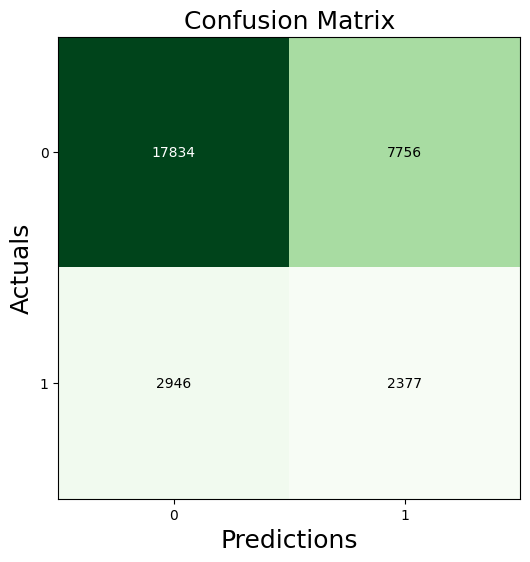

In [ ]:
fig, ax = plot_confusion_matrix(conf_mat= cm, figsize=(6, 6), cmap=plt.cm.Greens)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
parameters_hgb = [{'max_iter': [1000,1200,1500],
                'learning_rate': [0.1],
                'max_depth' : [25, 50, 75],
                'l2_regularization': [1.5],
                'scoring': ['f1_micro']}]

grid_search_hgb = GridSearchCV(estimator = hgb_clf,
                           param_grid = parameters_hgb,
                           scoring = 'accuracy',
                           cv = 10,
                           n_jobs = -1)

In [ ]:
grid_search_hgb.fit(X_train, y_train)
best_accuracy_hgb = grid_search_hgb.best_score_
best_paramaeter_hgb = grid_search_hgb.best_params_
print("Best Accuracy of HGB: {:.2f} %".format(best_accuracy_hgb.mean()*100))
print("Best Parameter of HGB:", best_paramaeter_hgb)

Best Accuracy of HGB: 85.08 %
Best Parameter of HGB: {'l2_regularization': 1.5, 'learning_rate': 0.1, 'max_depth': 75, 'max_iter': 1200, 'scoring': 'f1_micro'}
